## Plot alignment statistics for WT 8xdicodon barcodeseq

In [56]:
suppressPackageStartupMessages(library(Biostrings))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(rasilabRtemplates))
suppressPackageStartupMessages(library(boot))
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(gridExtra))

barcode_reads_cutoff <- 10
set.seed(1234)

### Global plotting themes

In [57]:
theme <- theme(
        title = element_text(margin = margin(t=0, r=2, b=2, l=2), size=8),
        axis.title.x = element_text(margin = margin(t=2, r=2, b=0, l=2), size=8),
        axis.title.y = element_text(margin = margin(t=2, r=2, b=2, l=0), size=8),
        text = element_text(size = 8),
        legend.text=element_text(size=8),
        axis.line.x=element_line(size=0.2),
        axis.line.y=element_line(size=0.2),
        axis.ticks.y =  element_line(size=0.2),
        axis.ticks.x = element_line(size=0.2),
        axis.text.x = element_text(size=8),
        axis.text.y = element_text(size=8)
        )

In [58]:
if (!file.exists('../figures')){
    dir.create('../figures')
}

### Load sample annotations and barcode counts

In [59]:
sample_annotations = read_csv("../annotations/sample_annotations.csv", comment='#')
sample_annotations

Rows: 2 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): owner, sample_type, sample_name, plasmid, library_type, illumina_s...
dbl  (3): barcode_read, barcode_start, barcode_length

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


owner,sample_type,sample_name,plasmid,library_type,illumina_sample_id,sample_id,barcode_read,barcode_start,barcode_length,linkage_ref,r1_file,r2_file,s3,shared
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
kc,dicodon_yeast,wt_gdna,pHPSC1142,grna,51lib2,51lib2,1,1,24,yeast_cyto_linkage,kc_51lib2_S13_R1_001,kc_51lib2_S13_R2_001,fh-pi-subramaniam-a-eco/data/kchen/illumina/20220328_exp51_wt_8xdicodon/,/shared/ngs/illumina/subramaniam_lab/220328_VH00319_178_AAAYF3FM5/Unaligned/Project_subramaniam_lab/
kc,dicodon_yeast,wt_mrna,pHPSC1142,mrna,51lib1,51lib1,1,1,24,yeast_cyto_linkage,kc_51lib1_S12_R1_001,kc_51lib1_S12_R2_001,fh-pi-subramaniam-a-eco/data/kchen/illumina/20220328_exp51_wt_8xdicodon/,/shared/ngs/illumina/subramaniam_lab/220328_VH00319_178_AAAYF3FM5/Unaligned/Project_subramaniam_lab/


In [60]:
insert_annotations = read_csv("../../8xdicodon_linkage/annotations/dicodon_yeast.csv") %>%
    mutate(dicodon = str_extract(insert, "([ACTG]{6})(?=\\1{7})")) %>%
    drop_na(dicodon) %>% # drops the inserts that aren't dicodons in this case
    mutate(diaa = as.character(translate(DNAStringSet(dicodon), no.init.codon = T))) %>%
    mutate(codon1 = substr(dicodon, 1, 3), codon2 = substr(dicodon, 4, 6),
         aa1 = substr(diaa, 1, 1), aa2 = substr(diaa, 2, 2)) %>%
    select(-insert) %>%
    print()

Rows: 6000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): insert
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 4,096 × 7
   insert_num dicodon diaa  codon1 codon2 aa1   aa2  
        <dbl> <chr>   <chr> <chr>  <chr>  <chr> <chr>
 1          0 AAAAAA  KK    AAA    AAA    K     K    
 2          1 AAAAAC  KN    AAA    AAC    K     N    
 3          2 AAAAAG  KK    AAA    AAG    K     K    
 4          3 AAAAAT  KN    AAA    AAT    K     N    
 5          4 AAAACA  KT    AAA    ACA    K     T    
 6          5 AAAACC  KT    AAA    ACC    K     T    
 7          6 AAAACG  KT    AAA    ACG    K     T    
 8          7 AAAACT  KT    AAA    ACT    K     T    
 9          8 AAAAGA  KR    AAA    AGA    K     R    
10          9 AAAAGC  KS    AAA    AGC    K     S    
# … with 4,086 more rows


In [61]:
barcode_counts <- list.files("../data/linked_barcode_counts/", pattern = ".csv$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_csv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(barcode_count = as.numeric(barcode_count)) %>%
  mutate(linkage_count = as.numeric(linkage_count))

Rows: 197785 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 172594 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(counts)`”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


### Load linkages and annotations

In [62]:
insert_barcode_linkages <- read_csv("../../8xdicodon_linkage/data/filtered_barcodes/yeast_cyto_linkage.csv") %>%
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(linkage_count = as.numeric(linkage_count)) %>%
  mutate(linkage_ref = 'yeast_cyto_linkage')

head(insert_barcode_linkages)

Rows: 2455063 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


insert_num,barcode_num,barcode,linkage_count,linkage_ref
<dbl>,<dbl>,<chr>,<dbl>,<chr>
NA,1,barcode,NA,yeast_cyto_linkage
4457,2,GGGCTTAAGAAGATCCTTGTCAGG,99,yeast_cyto_linkage
4123,3,TAGCACATTTCCTCTGGGGTTCGT,99,yeast_cyto_linkage
4793,4,TACTGTTTTGCTCGTGGCGTTTAT,99,yeast_cyto_linkage
180,5,GAGAGGTGGATCGCGCACAGCAAG,99,yeast_cyto_linkage
4969,6,GGGGTGTATAGGACCGGCCAGTCT,99,yeast_cyto_linkage


In [63]:
insert_annotations = read_csv("../../8xdicodon_linkage/annotations/dicodon_yeast.csv") %>%
    mutate(dicodon = str_extract(insert, "([ACTG]{6})(?=\\1{7})")) %>%
    drop_na(dicodon) %>% # drops the inserts that aren't dicodons in this case
    mutate(diaa = as.character(translate(DNAStringSet(dicodon), no.init.codon = T))) %>%
    mutate(codon1 = substr(dicodon, 1, 3), codon2 = substr(dicodon, 4, 6),
         aa1 = substr(diaa, 1, 1), aa2 = substr(diaa, 2, 2)) %>%
    select(-insert) %>%
    print()

Rows: 6000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): insert
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 4,096 × 7
   insert_num dicodon diaa  codon1 codon2 aa1   aa2  
        <dbl> <chr>   <chr> <chr>  <chr>  <chr> <chr>
 1          0 AAAAAA  KK    AAA    AAA    K     K    
 2          1 AAAAAC  KN    AAA    AAC    K     N    
 3          2 AAAAAG  KK    AAA    AAG    K     K    
 4          3 AAAAAT  KN    AAA    AAT    K     N    
 5          4 AAAACA  KT    AAA    ACA    K     T    
 6          5 AAAACC  KT    AAA    ACC    K     T    
 7          6 AAAACG  KT    AAA    ACG    K     T    
 8          7 AAAACT  KT    AAA    ACT    K     T    
 9          8 AAAAGA  KR    AAA    AGA    K     R    
10          9 AAAAGC  KS    AAA    AGC    K     S    
# … with 4,086 more rows


In [64]:
barcode_insert_counts <- barcode_counts %>% 
  left_join(select(sample_annotations, c(sample_id, sample_name)), by = "sample_name") %>%
  left_join(insert_barcode_linkages, by = c("barcode_num", "barcode", "insert_num", "linkage_count")) %>%
  drop_na(barcode_count) %>%
  select(-sample_id)

head(barcode_insert_counts)

barcode_count,insert_num,barcode_num,barcode,linkage_count,sample_name,linkage_ref
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
4871,186,1643847,AGTCGTTGTAGCAACTCGATGTTT,16,wt_gdna,yeast_cyto_linkage
4653,5658,1596380,CTGGATGTCGCGAGCAACAACAGC,17,wt_gdna,yeast_cyto_linkage
3823,5810,764917,TGTATTCGGGCCAGCATGAGGTGC,4,wt_gdna,yeast_cyto_linkage
3656,2787,1040412,AGCGATTAGAGCATTTCTGGCCAC,3,wt_gdna,yeast_cyto_linkage
3577,203,1644177,TGGGATCTTTTCGCGTATTCGGTT,16,wt_gdna,yeast_cyto_linkage
3497,4868,692986,TCGCTCCGTGTCGTGTCTCCTATG,4,wt_gdna,yeast_cyto_linkage


### Plot CDF reads per barcode

In [66]:
linkage <- insert_barcode_linkages %>%
    inner_join(insert_annotations, by='insert_num') %>%
    dplyr::rename(count=linkage_count) %>%
    select(insert_num, barcode_num, barcode, count) %>%
    mutate(library_type = 'plasmid')

In [67]:
dicodon_barcode_counts <- barcode_insert_counts %>%
    inner_join(insert_annotations, by='insert_num') %>%
    mutate(genotype = str_extract(sample_name, '^[^_]+')) %>%
    mutate(library_type = str_extract(sample_name, '[^_]+$')) %>%
    dplyr::rename(count=barcode_count) %>%
    mutate(library_type = ifelse(library_type == 'gdna', 'genomic DNA', 'cDNA')) %>%
    select(insert_num, barcode_num, barcode, count, library_type) %>%
    bind_rows(linkage)

### Plot CDF barcodes per insert

`summarise()` has grouped output by 'library_type'. You can override using the
`.groups` argument.


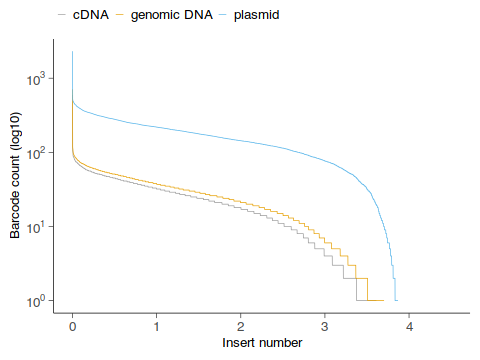

In [68]:
dicodon_barcode_counts %>%
    filter(count > 10) %>%
    group_by(library_type, insert_num) %>%
    summarize(n_barcodes = n()) %>%
    arrange(desc(n_barcodes)) %>%
    mutate(xaxis = (1:dplyr::n())/1000) %>%
    ggplot() +
    aes(x=xaxis, y=n_barcodes, color=library_type) + 
    geom_line(size=0.2) +
    scale_y_log10(
    breaks = scales::trans_breaks("log10", n=4, function(x) 10^x),
    labels = scales::trans_format("log10", scales::math_format(10^.x))
    ) +
    scale_x_continuous(breaks=seq(0,4,1), limits=c(0,4.5)) +
    theme +
    theme(
        legend.position = "top",
        legend.justification='left',
        legend.box.margin=margin(-12,-12,-12,-12),
        legend.key.width = unit(0.4, "line"),
        ) +
    labs(x='Insert number', y='Barcode count (log10)', color='')

ggsave("../figures/sfig1_cdf_barcodes_per_insert.pdf", width=2, height=2)

In [76]:
linkage %>%
    group_by(insert_num) %>%
    summarize(n=n(), .groups='drop') %>%
    mutate(median(n)) %>%
    slice(1) %>%
    select(-insert_num)

linkage %>%
    filter(count >= 10) %>%
    group_by(insert_num) %>%
    summarize(n=n(), .groups='drop') %>%
    mutate(median(n)) %>%
    slice(1) %>%
    select(-insert_num)

insert_num,n,median(n)
<dbl>,<int>,<dbl>
0,35,382


insert_num,n,median(n)
<dbl>,<int>,<dbl>
1,112,162


### Plot mRNA levels of selected dicodons from full library

In [15]:
wt_dicodon_nocutoffs <- barcode_counts %>%
    mutate(sample_type = str_extract(sample_name, '[^_]+$')) %>%
    mutate(sample_name = str_extract(sample_name, '[^_]+')) %>%
    filter(sample_name == 'wt') %>%
    inner_join(insert_annotations, by='insert_num') %>%
    select(-barcode, -aa1, -aa2, -codon1, -codon2) %>%
    pivot_wider(names_from='sample_type', values_from=c(barcode_count)) %>%
    drop_na()

In [16]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$gdna))
}

wt_bootstrap_dicodon_nocutoffs <- wt_dicodon_nocutoffs %>%
  group_by(dicodon) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  inner_join(insert_annotations, by = "dicodon") %>%
  mutate(strain = 'wt')

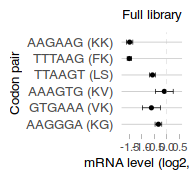

In [18]:
options(repr.plot.width = 1.6, repr.plot.height = 1.5)

order <- c("AAGGGA (KG)", "GTGAAA (VK)", "AAAGTG (KV)", "TTAAGT (LS)", "TTTAAG (FK)", "AAGAAG (KK)")

wt_bootstrap_dicodon_nocutoffs %>%
    mutate(name = str_c(dicodon, ' (', diaa, ')')) %>%
    filter(name %in% order) %>%
    mutate(codon = factor(name, level=order)) %>%
    ggplot(aes(x = lfc_med, y = codon,
             xmin = lfc_med - lfc_sd, xmax = lfc_med + lfc_sd)) +
    geom_errorbar(width=0.3, size=0.2) +
    geom_point(size=0.8) +
    geom_vline(xintercept=0, color='grey', size=0.1, linetype=2) +
    scale_color_manual(values='black') +
    scale_x_continuous(breaks=seq(-1.5, 0.5, 0.5), limits=c(-1.7, 0.5)) +
    theme + 
    theme(
        axis.line = element_blank(),
        axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.ticks.x = element_line(size=0.1),
        panel.grid.major.y = element_line(color='grey', size=0.2),
        legend.text=element_blank(),
        axis.text.x = element_text(size=7),
        ) +
    labs(x = "mRNA level (log2, a.u.)", y = "Codon pair", subtitle='Full library')

ggsave("../figures/sfig2_select_targeted_dicodon_effects_in_full_lib.pdf",  width=2.2, height=1.8)

### Plot GC content

In [19]:
insert_annotations_gc <- read_csv("../../8xdicodon_linkage/annotations/dicodon_yeast.csv") %>% 
  mutate(dicodon = str_extract(insert, "([ACTG]{6})(?=\\1{7})")) %>% 
  # calculate gc3
  bind_cols(DNAStringSet(.$insert) %>% 
              subseq(start=3) %>% 
              oligonucleotideFrequency(1, 3) %>% 
              as_tibble() %>% 
              rename_all(. %>% paste0("3")) %>% 
              mutate(gc3 = (G3 + C3) / (A3 + C3 + G3 + T3)) %>% 
              select(gc3)
            ) %>% 
  # calculate gc
  bind_cols(DNAStringSet(.$insert) %>% 
              oligonucleotideFrequency(1, 1) %>% 
              as_tibble() %>% 
              mutate(gc = (G + C) / (A + C + G + T)) %>% 
              select(gc)
            )

Rows: 6000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): insert
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [20]:
barcode_reads_cutoff <- 10

In [21]:
gc_lfc <- barcode_counts %>%
    filter(barcode_count >= barcode_reads_cutoff) %>%
    group_by(sample_name, insert_num) %>%
    summarize(insert_count = sum(barcode_count), n_barcodes = n(), .groups='drop') %>%
    inner_join(insert_annotations_gc, by = "insert_num") %>% # gets rid of the 6000-4096 inserts that aren't dicodons
    mutate(sample_type = str_extract(sample_name, '[^_]+$')) %>%
    mutate(sample_name = str_extract(sample_name, '[^_]+')) %>%
    pivot_wider(names_from = sample_type, values_from = c(insert_count, n_barcodes)) %>%
    drop_na() %>%
    group_by(sample_name) %>%
    mutate(lfc_no_norm = log2(insert_count_mrna) - log2(insert_count_gdna)) %>%
    mutate(lfc = lfc_no_norm - median(lfc_no_norm)) %>%
    ungroup() %>%
    mutate(gc_content = factor(round((gc*100),0))) %>%
    mutate(gc3_content = factor(round((gc3*100),0)))

In [22]:
label_data <- gc_lfc %>% 
  group_by(sample_name) %>% 
  nest() %>% 
  mutate(n = map_int(data, nrow), fit = map(data, function(df) cor.test(~gc + lfc, data = df))) %>% 
  mutate(fit = map(fit, broom::tidy)) %>% 
  unnest(fit, n) %>% 
  select(-data) %>%
  mutate(estimate = paste0("r=", round(estimate, 2)))

label_data

Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(fit, n))`, with `mutate()` if needed”


sample_name,n,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<chr>,<int>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>
wt,3617,r=0.17,10.07654,1.432128e-23,3615,0.1334159,0.1968193,Pearson's product-moment correlation,two.sided


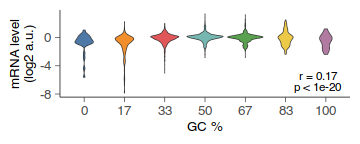

In [23]:
options(repr.plot.width = 3, repr.plot.height = 1.2)

gc_lfc %>%
    ggplot() +
    geom_violin(size=0.2) +
    aes(x=gc_content, y=lfc, fill=gc_content) +
    theme + 
    theme(
        axis.line = element_blank(),
        legend.text=element_blank(),
        strip.text.x = element_blank()
        ) +
    ggthemes::scale_fill_tableau() +
    annotate('text', x=6.8, y = -5.5, label = str_c('r = 0.17'), size=7/.pt) +
    annotate('text', x=6.8, y = -7, label = str_c('p < 1e-20'), size=7/.pt) +
    labs(x='GC %', y='mRNA level\n(log2 a.u.)') +
    guides(fill="none")

ggsave("../figures/sfig2_wt_gc_lfc_corr.pdf", width=2.8, height=1.5)

In [24]:
label_data <- gc_lfc %>% 
  group_by(sample_name) %>% 
  nest() %>% 
  mutate(n = map_int(data, nrow), fit = map(data, function(df) cor.test(~gc3 + lfc, data = df))) %>% 
  mutate(fit = map(fit, broom::tidy)) %>% 
  unnest(fit, n) %>% 
  select(-data) %>%
  mutate(estimate = paste0("r=", round(estimate, 2)))

label_data

Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(fit, n))`, with `mutate()` if needed”


sample_name,n,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<chr>,<int>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>
wt,3617,r=0.12,7.462015,1.061583e-13,3615,0.09093755,0.1551322,Pearson's product-moment correlation,two.sided


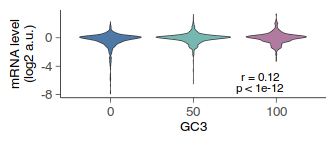

In [25]:
options(repr.plot.width = 2.8, repr.plot.height = 1.2)

gc_lfc %>%
    ggplot() +
    aes(x=gc3_content, y=lfc, fill=gc3_content) +
    facet_wrap(~sample_name) +
    geom_violin(size=0.2) +
    theme + 
    theme(
        axis.line = element_blank(),
        legend.text=element_blank(),
        strip.text.x = element_blank()
        ) +
    scale_fill_manual(values=c('0'='#4e79a7', '50'='#76b7b2', '100'='#b07aa1')) +
    annotate('text', x = 2.8, y = -5.5, label = str_c('r = 0.12'),  size=7/.pt) +
    annotate('text', x = 2.8, y = -7.0, label = str_c('p < 1e-12'),  size=7/.pt) +
    labs(x='GC3', y='mRNA level\n(log2 a.u.)') +
    guides(fill="none")

ggsave("../figures/sfig2_wt_gc3_lfc_corr.pdf", width=1.7, height=1.5)

### Plot mRNA levels of selected dicodons in mini pool deepsequencing

In [26]:
barcode_counts_mini  <- list.files("../../wt_hel2_mini_pool/data/linked_barcode_counts/", pattern = ".csv$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_csv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(barcode_count = as.numeric(barcode_count)) %>%
  mutate(linkage_count = as.numeric(linkage_count))

Rows: 1209 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1209 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 922 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column typ

In [27]:
insert_annotations_mini <- read_csv("../../mini_8xdicodon_linkage/annotations/dicodon_yeast.csv") %>%
    mutate(diaa = as.character(translate(DNAStringSet(insert), no.init.codon = T))) %>%
    mutate(diaa = str_sub(diaa, 9,10)) %>%
    mutate(dicodon = str_sub(insert, 25,30)) %>%
    mutate(diaa = ifelse(insert_num == 11, 'spikein2', diaa)) %>%
    mutate(diaa = ifelse(insert_num == 12, 'spikein2', diaa))

Rows: 13 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): insert
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in .Call2("DNAStringSet_translate", x, skip_code, dna_codes[codon_alphabet], :
“in 'x[[1]]': last 2 bases were ignored”
Warning message in .Call2("DNAStringSet_translate", x, skip_code, dna_codes[codon_alphabet], :
“in 'x[[2]]': last 2 bases were ignored”
Warning message in .Call2("DNAStringSet_translate", x, skip_code, dna_codes[codon_alphabet], :
“in 'x[[3]]': last 2 bases were ignored”
Warning message in .Call2("DNAStringSet_translate", x, skip_code, dna_codes[codon_alphabet], :
“in 'x[[4]]': last 2 bases were ignored”
Warning message in .Call2("DNAStringSet_translate", x, skip_code, dna_codes[codon_alphabet], :
“in 'x[[5]]': last 2 bases were ignored”
Warning messa

In [28]:
include <- c("AAGGGA", "TTAAGT", "GTGAAA", "AAAGTG", "TTTAAG", "AAGAAG")
insert_reads_cutoff <- 15
AMINO_ACID_CODE["*"] = "*"

calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$gdna))
}

diaa_lfc_boot_wt_mini <- barcode_counts_mini %>%
  left_join(insert_annotations_mini, by='insert_num') %>%
  mutate(sample_type = str_extract(sample_name, '[^_]+$')) %>%
  mutate(genotype = str_extract(sample_name, '[^_]+')) %>%
  filter(genotype == 'wt') %>%
  select(-barcode, -linkage_count, -sample_name) %>%
  pivot_wider(names_from = c(sample_type), values_from = barcode_count) %>%
  filter((mrna >= insert_reads_cutoff) & (gdna >= insert_reads_cutoff)) %>%
  drop_na() %>%
  group_by(insert_num) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  inner_join(insert_annotations_mini, by = "insert_num") %>%
  mutate(strain = 'WT')

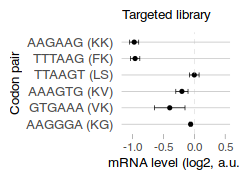

In [29]:
options(repr.plot.width = 2, repr.plot.height = 1.5)

order <- c("AAGGGA (KG)", "GTGAAA (VK)", "AAAGTG (KV)", "TTAAGT (LS)", "TTTAAG (FK)", "AAGAAG (KK)")

plot_data <- diaa_lfc_boot_wt_mini %>%
  filter(dicodon %in% include) %>%
  mutate(lfc_max = lfc - max(lfc)) %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  mutate(diaa = str_c(dicodon, " (", diaa, ")")) %>%
  mutate(codon = factor(diaa, level=order))

plot_data %>%
  ggplot(aes(x = lfc_max, y = codon,
             xmin = lfc_max - lfc_sd, xmax = lfc_max + lfc_sd)) +
  geom_errorbar(width=0.3, size=0.2) +
  geom_point(size=0.8) +
  geom_vline(xintercept=0, color='grey', size=0.1, linetype=2) +
  scale_x_continuous(breaks=seq(-1.5, 0.5, 0.5), limits=c(-1.1, 0.5)) +
  scale_color_manual(values='black') +
  theme + 
  theme(
      axis.line = element_blank(),
      axis.line.x = element_blank(),
      axis.line.y = element_blank(),
      axis.ticks.y = element_blank(),
      axis.ticks.x = element_line(size=0.1),
      panel.grid.major.y = element_line(color='grey', size=0.2),
      legend.text=element_blank(),
      axis.text.x = element_text(size=7),
      ) +
  labs(x = "mRNA level (log2, a.u.)", y = "Codon pair", subtitle='Targeted library')

ggsave("../figures/sfig2_targeted_deepseq.pdf",  width=2.2, height=1.8)